In [1]:
import pymongo
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Connect with the MongoDB Server
client = pymongo.MongoClient('localhost', 27017)
db = client['comp6235']
all_weather = db['all_weather']
london_historical_weather = db['london_historical_weather']
uk_energy = db['uk_energy']

In [3]:
# Select historical temperature data from London_historical_Weather Dataset
query_past_t = [
    {
        "$set": {
            "date": {
                "$toDate": {
                    "$dateToString": {
                        "date": {"$dateFromParts": {"year": {"$floor": {"$divide": ["$date", 10000]}},"month": {"$floor": {"$mod": [{"$divide": ["$date", 100]}, 100]}},"day": {"$mod": ["$date", 100]}}},
                        "format": "%Y-%m-%d"
                    }
                }
            }
        }
    },
    {'$sort':{'_id':1}}
]

result_past_t = london_historical_weather.aggregate(query_past_t)
df = pd.DataFrame(list(result_past_t))
df

,_id,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,6572ae475bffd97e20d7f19c,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,6572ae475bffd97e20d7f19d,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,6572ae475bffd97e20d7f19e,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,6572ae475bffd97e20d7f19f,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,6572ae475bffd97e20d7f1a0,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
15336,6572ae475bffd97e20d82d84,2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,0.0
15337,6572ae475bffd97e20d82d85,2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,0.0
15338,6572ae475bffd97e20d82d86,2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,0.0
15339,6572ae475bffd97e20d82d87,2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,0.0


## LSTM Prediction based on the Historical Dataset

Epoch 1/20
384/384 - 6s - loss: 0.0088 - 6s/epoch - 16ms/step
Epoch 2/20
384/384 - 2s - loss: 0.0047 - 2s/epoch - 4ms/step
Epoch 3/20
384/384 - 2s - loss: 0.0042 - 2s/epoch - 5ms/step
Epoch 4/20
384/384 - 2s - loss: 0.0038 - 2s/epoch - 4ms/step
Epoch 5/20
384/384 - 2s - loss: 0.0034 - 2s/epoch - 4ms/step
Epoch 6/20
384/384 - 2s - loss: 0.0032 - 2s/epoch - 4ms/step
Epoch 7/20
384/384 - 2s - loss: 0.0032 - 2s/epoch - 4ms/step
Epoch 8/20
384/384 - 2s - loss: 0.0032 - 2s/epoch - 4ms/step
Epoch 9/20
384/384 - 2s - loss: 0.0032 - 2s/epoch - 4ms/step
Epoch 10/20
384/384 - 2s - loss: 0.0032 - 2s/epoch - 4ms/step
Epoch 11/20
384/384 - 2s - loss: 0.0032 - 2s/epoch - 4ms/step
Epoch 12/20
384/384 - 2s - loss: 0.0031 - 2s/epoch - 4ms/step
Epoch 13/20
384/384 - 2s - loss: 0.0031 - 2s/epoch - 4ms/step
Epoch 14/20
384/384 - 2s - loss: 0.0032 - 2s/epoch - 4ms/step
Epoch 15/20
384/384 - 2s - loss: 0.0031 - 2s/epoch - 4ms/step
Epoch 16/20
384/384 - 2s - loss: 0.0031 - 2s/epoch - 4ms/step
Epoch 17/20
384/

Text(0.8, 0.05, 'Accuracy: 86.80%')

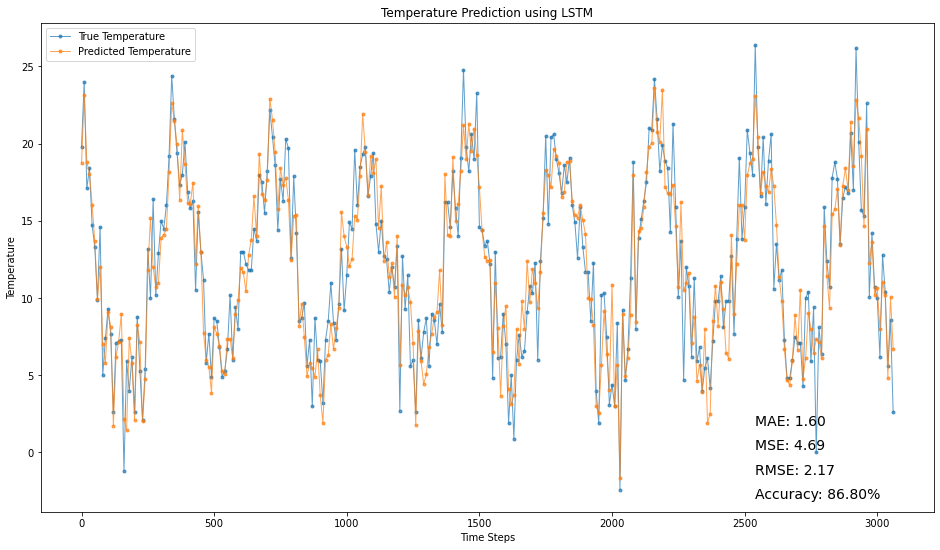

In [4]:
# Select Temperature Data and Reshape them
temperature_data = df['mean_temp'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_data_scaled = scaler.fit_transform(temperature_data)

# Create Time Series Data
def create_time_series(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Set time steps
time_steps = 10

# Create Time Series Data
X, y = create_time_series(temperature_data_scaled, time_steps)

# Seperate into Training data and Testing data
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Transform into three dimensions (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

# Predict on the Testset
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualization
plt.figure(figsize=(16, 9))
plt.plot(range(0, len(y_test_actual), 10), y_test_actual[::10], label='True Temperature', marker='.', linewidth=1, alpha=0.7)
plt.plot(range(0, len(y_pred), 10), y_pred[::10], label='Predicted Temperature', marker='.', linewidth=1, alpha=0.7)
plt.title('Temperature Prediction using LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()

# Calculate the accuracy and other metrics
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
accuracy = 1 - mae / np.mean(y_test_actual)

# annotate
plt.text(0.80, 0.20, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.80, 0.15, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.80, 0.10, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.80, 0.05, f'Accuracy: {accuracy:.2%}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

## Predict the Extreme Days based on Historical Days

In [16]:
query_extreme = [
    {'$match':{'max_temp':{'$gt':30}}},
    {
        "$set": {
            "date": {
                "$toDate": {
                    "$dateToString": {
                        "date": {"$dateFromParts": {"year": {"$floor": {"$divide": ["$date", 10000]}},"month": {"$floor": {"$mod": [{"$divide": ["$date", 100]}, 100]}},"day": {"$mod": ["$date", 100]}}},
                        "format": "%Y-%m-%d"
                    }
                }
            }
        }
    },
    {'$group':{'_id':{'$year':{'$toDate':'$date'}},'extreme_count':{'$sum':1}}},
    {'$sort':{'_id':1}}
]

result_extreme = london_historical_weather.aggregate(query_extreme)
df_extreme = pd.DataFrame(list(result_extreme))
df_extreme

,_id,extreme_count
0,1983,8
1,1984,3
2,1986,3
3,1989,5
4,1990,9
5,1992,1
6,1994,6
7,1995,16
8,1996,6
9,1997,3


In [19]:
all_years = pd.DataFrame({'Year': range(1981, df_extreme['_id'].max() + 1)})

# Combined two dataframe
merged_df = pd.merge(all_years, df_extreme, left_on='Year', right_on='_id', how='left')

merged_df = merged_df.rename(columns={'_id': 'Year_x', 'extreme_count': 'Extreme Days'}).fillna(0).astype({'Year': int})

merged_df = merged_df.drop(columns='Year_x')

merged_df

,Year,Extreme Days
0,1981,0.0
1,1982,0.0
2,1983,8.0
3,1984,3.0
4,1985,0.0
5,1986,3.0
6,1987,0.0
7,1988,0.0
8,1989,5.0
9,1990,9.0


Epoch 1/100
1/1 - 2s - loss: 0.1148 - 2s/epoch - 2s/step
Epoch 2/100
1/1 - 0s - loss: 0.1129 - 5ms/epoch - 5ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1111 - 5ms/epoch - 5ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1093 - 6ms/epoch - 6ms/step
Epoch 5/100
1/1 - 0s - loss: 0.1075 - 5ms/epoch - 5ms/step
Epoch 6/100
1/1 - 0s - loss: 0.1058 - 4ms/epoch - 4ms/step
Epoch 7/100
1/1 - 0s - loss: 0.1041 - 4ms/epoch - 4ms/step
Epoch 8/100
1/1 - 0s - loss: 0.1024 - 5ms/epoch - 5ms/step
Epoch 9/100
1/1 - 0s - loss: 0.1008 - 5ms/epoch - 5ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0993 - 5ms/epoch - 5ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0977 - 6ms/epoch - 6ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0962 - 5ms/epoch - 5ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0948 - 4ms/epoch - 4ms/step
Epoch 14/100
1/1 - 0s - loss: 0.0934 - 6ms/epoch - 6ms/step
Epoch 15/100
1/1 - 0s - loss: 0.0920 - 4ms/epoch - 4ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0906 - 5ms/epoch - 5ms/step
Epoch 17/100
1/1 - 0s - loss: 0.0893 - 3ms/epoch - 

Text(0.8, 0.05, 'Accuracy: 47.43%')

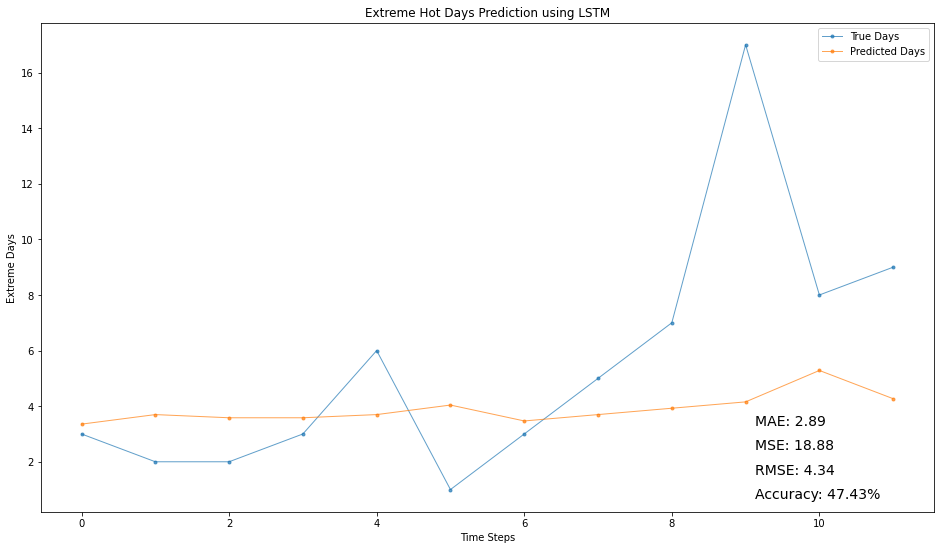

In [45]:
extreme_data = merged_df['Extreme Days'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
extreme_data_scaled = scaler.fit_transform(extreme_data)

def create_time_series(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 1

X, y = create_time_series(extreme_data_scaled, time_steps)

split = int(0.7 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(16, 9))
plt.plot(range(0, len(y_test_actual), 1), y_test_actual[::1], label='True Days', marker='.', linewidth=1, alpha=0.7)
plt.plot(range(0, len(y_pred), 1), y_pred[::1], label='Predicted Days', marker='.', linewidth=1, alpha=0.7)
plt.title('Extreme Hot Days Prediction using LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Extreme Days')
plt.legend()

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
accuracy = 1 - mae / np.mean(y_test_actual)

plt.text(0.80, 0.20, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.80, 0.15, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.80, 0.10, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.80, 0.05, f'Accuracy: {accuracy:.2%}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')